# Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

## Инструкция по выполнению проекта

1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Обучите и проверьте модель для каждого региона:
    1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
    2. Обучите модель и сделайте предсказания на валидационной выборке.
    3. Сохраните предсказания и правильные ответы на валидационной выборке.
    4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
    5. Проанализируйте результаты.
3. Подготовьтесь к расчёту прибыли:
    1. Все ключевые значения для расчётов сохраните в отдельных переменных.
    2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.
    3. Напишите выводы по этапу подготовки расчёта прибыли.
4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    1. Выберите скважины с максимальными значениями предсказаний. Количество скважин зависит от бюджета компании и стоимости разработки одной скважины.
    2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
    3. Рассчитайте прибыль для полученного объёма сырья.
5. Посчитайте риски и прибыль для каждого региона:
    1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

### Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


## Изучение данных

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from scipy import stats as st
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
data0.info()
display(data0.sample(5))
data0.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
92183,Vjg5p,-0.877745,0.613118,-1.242665,107.964464
51572,20g4q,0.028632,0.286877,2.005799,99.617845
97428,aliDG,1.518431,-0.220845,2.906486,146.444121
4034,5ulgL,1.921413,-0.061557,5.011095,138.114427
29126,rQ8ga,-0.568081,0.605734,-0.165120,25.996777


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [4]:
data1.info()
display(data1.sample(5))
data1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
12243,yyYoo,8.152942,-0.709834,5.003593,134.766305
96954,AmApb,-2.294089,-9.202508,4.998320,137.945408
20234,4Hpvz,-1.309507,-8.577872,1.998031,57.085625
27702,jzbhl,19.878471,-0.566273,0.008416,0.000000
84318,pXXd3,14.267235,-5.063901,3.990665,107.813044


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [5]:
data2.info()
display(data2.sample(5))
data2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
37592,mWbYx,-1.601235,-4.302809,-0.946159,35.345085
49166,MYxNp,-1.427800,2.205019,2.501670,44.904672
99742,i1HoK,2.202989,-2.917932,0.232930,65.893532
62260,XzCMy,0.821323,2.465785,2.185370,177.601037
65610,NHi83,2.024122,1.798824,2.735982,60.295275


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Посмотрев на данные, самое странное, что мы можем увидеть это нулевые значения в объёме запасов в скважине.

In [6]:
# data = pd.concat([data0, data1, data2])
# data.info()

Проверим данные на дубликаты.

In [7]:
print(data0.duplicated().sum())
print(data1.duplicated().sum())
print(data2.duplicated().sum())

0
0
0


Полных дупликатов не найдено. Посмотрим нет ли дубликатов по id.

In [8]:
print(data0['id'].duplicated().sum())
print(data1['id'].duplicated().sum())
print(data2['id'].duplicated().sum())

10
4
4


Есть дубликаты по id, так как таких данных не много удалим эти записи, оставив первую встретившуюся запись.

In [9]:
data0.drop_duplicates(subset=['id'], inplace=True)
data1.drop_duplicates(subset=['id'], inplace=True)
data2.drop_duplicates(subset=['id'], inplace=True)

print(data0['id'].duplicated().sum())
print(data1['id'].duplicated().sum())
print(data2['id'].duplicated().sum())

0
0
0


Посмотрим на распределение значений столбца product.

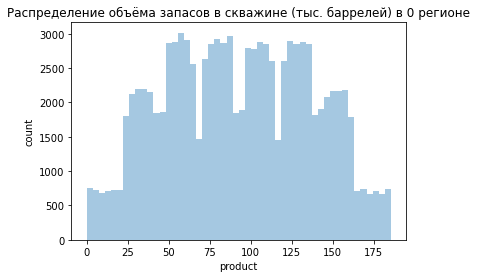

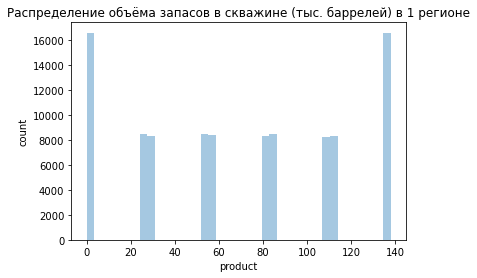

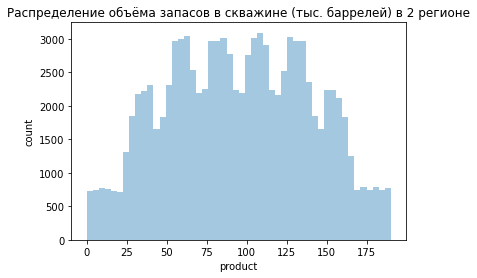

In [10]:
def hist_by_product(data, region_number):
    ax = sns.distplot(data['product'],kde = False)
    ax.set_title('Распределение объёма запасов в скважине (тыс. баррелей) в {} регионе'.format(region_number))
    ax.set_ylabel('count');
    plt.show()

hist_by_product(data0, 0)
hist_by_product(data1, 1)
hist_by_product(data2, 2)

Если распределение 0 и 2 регионов стремиться к нормальному, то в 1 регионе чаще либо не находят ничего, либо находят большой запас нефти. Так же видно, что скважины с большим максимальным объемом в 0 и 2 регионе. 

Мы можем увидеть большое количество нулевых значениях, вычищать эти данные не нужно, в дальнейшем модель нам сможет предсказывать, что по таким-то признакам в этом месте пусто. 

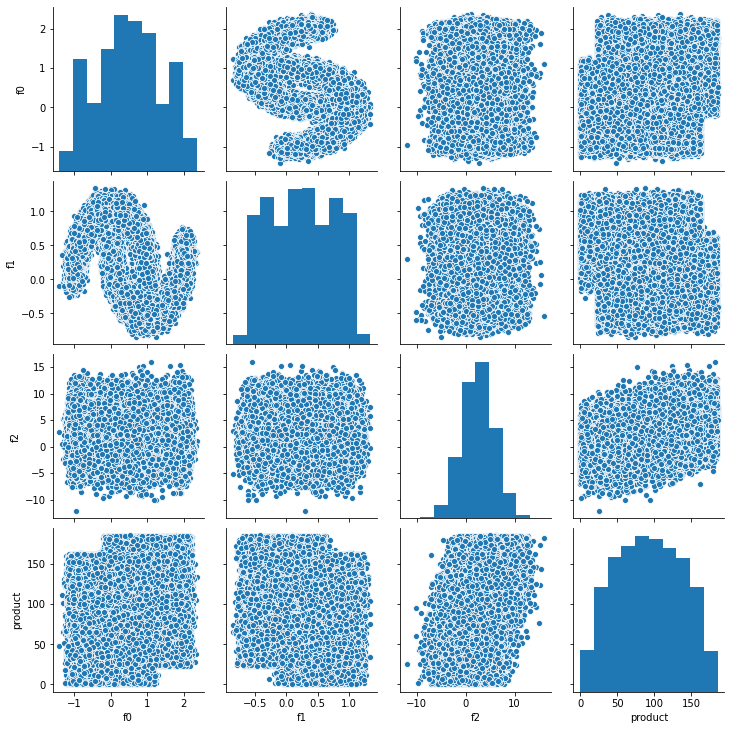

In [11]:
sns.pairplot(data0);

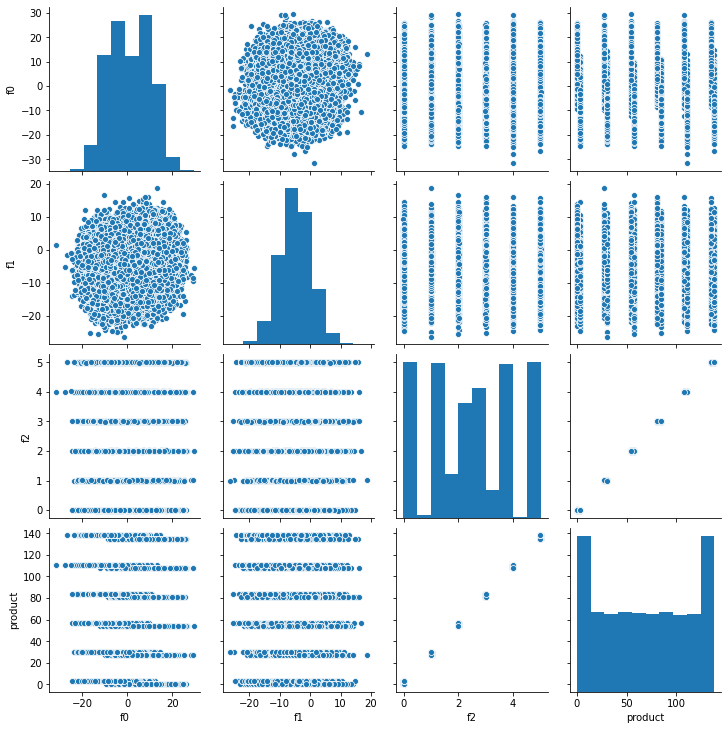

In [12]:
sns.pairplot(data1);

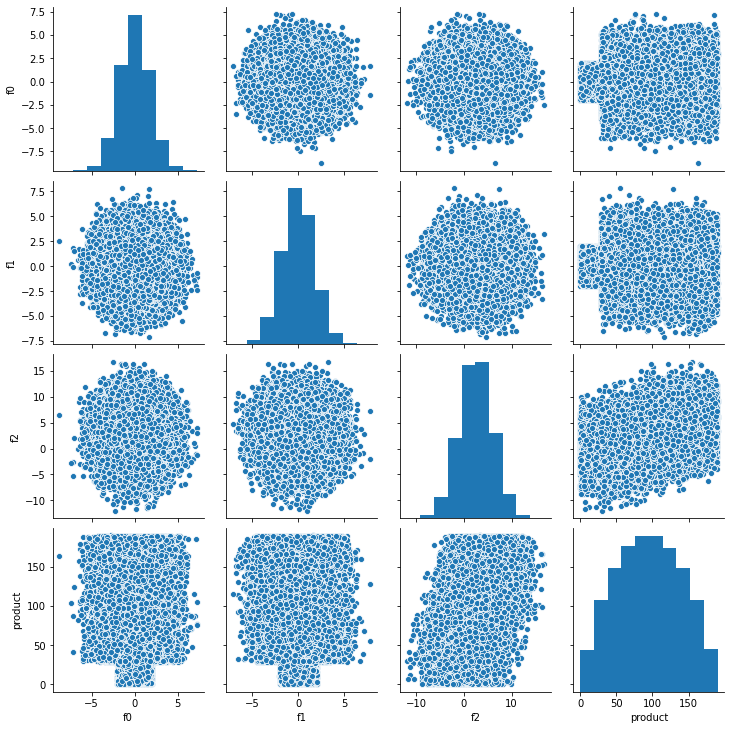

In [13]:
sns.pairplot(data2);

pairplot показал нам, что между данными во всех трёх датасетах нет мультиколлинеарности. Но в 1 регионе видно, что один из признаков сильно коррелирует с целевым признаком.

Очистим датасет от ненужного нам признака id. Этот признак никак не влияет на объём нефти в скважине.

In [14]:
data0.drop(labels=['id'], axis=1, inplace=True)
data1.drop(labels=['id'], axis=1, inplace=True)
data2.drop(labels=['id'], axis=1, inplace=True)


data0.info()
data1.info()
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99990 non-null  float64
 1   f1       99990 non-null  float64
 2   f2       99990 non-null  float64
 3   product  99990 non-null  float64
dtypes: float64(4)
memory usage: 6.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 6.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-nu

## Обучение и проверка моделей по трём регионам

In [15]:
def train_and_valid(data):
    X = data.drop('product', axis=1)
    y = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    print('Среднее: {}'.format(y_predicted.mean()))
    print('RMSE: {}'.format(mean_squared_error(y_valid, y_predicted) ** 0.5))
    return (pd.Series(y_valid), pd.Series(y_predicted))

In [16]:
print('Данные по 0 региону:')
print()
data0_target, data0_predicted = train_and_valid(data0)

Данные по 0 региону:

Среднее: 92.69968848318754
RMSE: 37.685286012491325


In [17]:
print('Данные по 1 региону:')
print()
data1_target, data1_predicted = train_and_valid(data1)

Данные по 1 региону:

Среднее: 69.0924815591112
RMSE: 0.8869956392892667


In [18]:
print('Данные по 2 региону:')
print()
data2_target, data2_predicted = train_and_valid(data2)

Данные по 2 региону:

Среднее: 94.83730859687569
RMSE: 39.800055589072635


Регионом с самым большим предсказанным средним значением это регион 2, но при этом это регион с самым большим RMSE. А регион с самым маленьким RMSE - 1, на это повлияла корреляция признака и целевого признака, найденная выше, поэтому отклонение здесь меньше, в отличие от остальных регионов.

## Подготовка к расчёту прибыли

In [19]:
budget = 10000000000
cost_per_barrel = 450
cost_per_unit = 450000
researh_well_count = 500
best_well_count = 200

In [20]:
profit_barrel_count = budget / cost_per_unit / best_well_count

print('Требуемое количество единиц (тыс.бар.): {}'.format(profit_barrel_count))

Требуемое количество единиц (тыс.бар.): 111.11111111111111


In [21]:
print('Среднее количество в 0 регионе: {}'.format(data0['product'].mean()))
print('Среднее количество в 1 регионе: {}'.format(data1['product'].mean()))
print('Среднее количество в 2 регионе: {}'.format(data2['product'].mean()))

Среднее количество в 0 регионе: 92.49968421774328
Среднее количество в 1 регионе: 68.82391591806625
Среднее количество в 2 регионе: 94.99834211933415


Хоть и требуемое значение для безубыточной добычи нефти выше средних показателей её количества в регионах, нас интересуют скважины с самым большим объемом, в 0 и 2 регионе много скважин где было > 175 тыс. баррелей, а в 1 пик приходится на скважины с объёмом в 137.9 тыс. баррелей. Поэтому цифра более чем достижимая, и даже если в каких то местах количество будет меньше предсказанного, то это количество можно будет компенсировать другими скважинами.

## Расчёт прибыли

In [22]:
state = np.random.RandomState(12345)

In [23]:
def calculate_revenue(target, predictions):
    sample = predictions.sample(researh_well_count, random_state=12345)
    top_200_well = target.iloc[sample.sort_values(ascending=False).head(200).index]
    total_unit_sum = top_200_well.sum()
    total_sum_by_region =  total_unit_sum * cost_per_unit
    revenue = total_sum_by_region - budget
    return revenue

In [24]:
print('Прибль по предсказаниям 0 региона: {}'.format(calculate_revenue(data0_target, data0_predicted)))
print('Прибль по предсказаниям 1 региона: {}'.format(calculate_revenue(data1_target, data1_predicted)))
print('Прибль по предсказаниям 2 региона: {}'.format(calculate_revenue(data2_target, data2_predicted)))

Прибль по предсказаниям 0 региона: 425380023.55212975
Прибль по предсказаниям 1 региона: 546230509.8654175
Прибль по предсказаниям 2 региона: 259769199.64887047


Мы написали функцию расчёта прибыли по предсказаниям:
- взяли случайные 500 скважин 
- выбрали лучшие 200
- посчитали общее количество баррелей из этих скважин
- посчитали сумму за эти баррели
- вычтили затраты на разработку скважин

Самую большую прибль мы получили от 1 региона, после её применения в разных регионах. А самую маленькую с 2-го региона.

## Расчёт рисков и прибыли для каждого региона

In [25]:
def get_revenue_and_risk(target, probabilities):
    state = np.random.RandomState(12345)

    values = []
    for i in range(1000):
        probs_subsample = probabilities.sample(frac=1, replace=True, random_state=state)
        values.append(calculate_revenue(target, probs_subsample))

    values = pd.Series(values)
    
    lower = values.quantile(0.025)
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    mean = values.mean()
    risk = (values < 0).mean()
    print("Средняя выручка:", mean)
    print("95% Доверительный интервал:", confidence_interval) 
    print('Риск убытков: {}'.format(risk))

In [26]:
get_revenue_and_risk(data0_target, data0_predicted)

Средняя выручка: 393493336.4905331
95% Доверительный интервал: (377846118.05639815, 409140554.9246681)
Риск убытков: 0.054


In [27]:
get_revenue_and_risk(data1_target, data1_predicted)

Средняя выручка: 444601953.6827761
95% Доверительный интервал: (432053286.74489397, 457150620.6206582)
Риск убытков: 0.011


In [28]:
get_revenue_and_risk(data2_target, data2_predicted)

Средняя выручка: 361901509.44838566
95% Доверительный интервал: (344886159.8453596, 378916859.0514117)
Риск убытков: 0.086


**Вывод:** самым прибыльным и безопасным по предсказаниям модели для бизнеса оказался 1 регион, предполагаемая прибыль входит в интервал от 447,5 до 472,8 млн., а риск убытков составляет всего лишь 1%. А самым неудачным 2 регион, там самая маленькая средняя выручка и риски в практически в 10%. Возможно это связано с тем, что модели удалось предсказывать этот регион лучше всего, т.к. один из признаков сильно коррелирует с целевым признаком. Но мы не полагались только лишь на предсказания, с помощью техники bootstrep нам удалось получить 95% доверительный интервал и вычислить риски для бизнеса.